In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import pandas as pd
from astropy.io import ascii
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import lightkurve as lk
from sklearn.inspection import permutation_importance
import math as m
from sklearn.metrics import r2_score
from rfpimp import permutation_importances
import LS_modular
import bls_modular
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from astroquery.mast import Observations, Catalogs

/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


## Useful functions

In [23]:
#pd.set_option('display.max_columns', None) #to show all columns
# pd.reset_option(“max_columns”) #to go back to hiding default number of columns





## make a fcn to recall label meanings easily
def label_meanings(label):
    ''' 
    1== Bad = "my measured rate DOES NOT match McQuillan"; 
    2== Half = "DOUBLE my measured rate matches McQuillan";
    3== Good = "my measured rate matches McQuillan" 
    '''
    mydictionary = {1:'Bad',2:'Half Harmonic',3:'Good'}
    return(mydictionary[label])

def abs_mag(m,D):
    '''
    ~converts apparent mag to absolute mag~
    args:
          m: apparent mag
          D: 1/parallax in parsecs
    RETURNS: absolute mag
    '''
    return m - 5*np.log10(D) + 5

def mas_to_parsec(mas):
    '''
    ~converts milliarcseconds(mas) to parsecs, useful b/c Gaia parallax in mas~
    args:
         mas: parallax measure in mas
    RETURNS: parallax in parsecs
    '''
    return mas * 1000

def get_D(parallax):
    '''
    ~converts parallax to distance~
    args:
        parrallax: parallax measure in mas
    RETURNS: distance
    '''
    plx = mas_to_parsec(parallax)
    return 1/plx

def slope(x1,x2,y1,y2):
    ''' 
    inputs: coordinates for 2 plotted datapoints
    returns: slope
    '''
    m = (y2 -y1) / (x2-x1)
    return (y2 -y1) / (x2-x1)

def get_b(m,x,y):
    '''
    gives y-intercept(b) for a straight line
    inputs: slope(m); point on line(x,y)
    returns: b
    '''
    b = -(m*x) + y
    return b

# Load Data

In [17]:
#open predcitions to pass on, has limited features
unseen_RF2_results = pd.read_csv('data/RF2_results.csv')
#has all features
allstats = pd.read_csv('/Volumes/Seagate-stars/SECTORS/allstats_14_15.csv')
#for comparisons
mq = pd.read_csv('data/mcquillan_sample.csv')

## all stats that are McQuillan matches table
matches_table = pd.read_csv('/Volumes/Seagate-stars/SECTORS/MQmatches_allstats_14_15.csv')

## all stats from CVZ that ls-1 were verified by eye to be correct - used in original RF classifier
cvz_examples = pd.read_csv('data/good_cvz_stats_for_RF.csv')



## Format Training Labels

In [18]:
## use rel_tol to add data to groups
goodtable = matches_table[[m.isclose(matches_table['ls-1'][i],matches_table['MQ_Prot'][i],rel_tol=.15) for i in range(len(matches_table))]]
halftable = matches_table[[m.isclose(matches_table['ls-1'][i]*2,matches_table['MQ_Prot'][i],rel_tol=.15) for i in range(len(matches_table))]]
goodindices = list(goodtable.index) + list(halftable.index) #get index of rows in good/half tables
badtable = matches_table[~matches_table.index.isin(goodindices)] #select index if NOT in goodindices aka bad

## add label column to each groups table
badtable['Label'] = np.repeat(1,len(badtable))
halftable['Label'] = np.repeat(1,len(halftable)) #temp change to good to see if better precison
goodtable['Label'] = np.repeat(3,len(goodtable))

## make one table 
fulltable = pd.concat([goodtable,halftable,badtable])
fulltable #sanity check


/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

,TIC,period_bls,power_bls,depth_bls,dur_bls,tt_bls,Sector,rvar,ls-1,ls-2,...,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID,KIC_y,MQ_Prot,Label
14,27773745,0.301299,24,0.000140,0.29,0.150,14,380.604883,4.158775,5.952853,...,296.264398,48.830980,0.022841,0.029273,1,0,332850229,11200185,4.36,3
15,27773745,0.303039,56,0.000124,0.29,0.168,15,486.554688,4.458739,6.426258,...,296.264398,48.830980,0.022841,0.029273,1,0,332850229,11200185,4.36,3
16,27776588,0.301679,31,0.000082,0.29,0.149,14,82.093555,12.513233,4.943627,...,296.270920,50.237531,0.021601,0.025449,1,0,332851766,11923356,14.13,3
19,27843903,0.307878,144,0.000129,0.29,0.152,14,120.960645,0.791619,0.761929,...,296.494114,51.244549,0.020114,0.024696,1,0,334931942,12418959,0.78,3
20,27843903,0.300162,3,0.000119,0.29,0.153,15,87.112500,0.796663,0.767347,...,296.494114,51.244549,0.020114,0.024696,1,0,334931942,12418959,0.78,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
219,158273158,0.302985,55,0.000103,0.29,0.151,15,71.861328,6.062904,13.605417,...,286.648223,46.564645,0.028236,0.029480,1,0,244054996,9760362,17.95,1
221,159171617,0.306220,114,0.000132,0.29,0.157,15,61.229785,4.031304,5.056476,...,289.734674,46.645304,0.085614,0.087636,1,0,269803158,9826171,10.72,1
222,159172010,0.300000,0,0.000194,0.29,0.150,15,56.993359,7.508752,5.348873,...,289.713639,46.945308,0.100010,0.094780,1,0,269803355,10006542,30.90,1
224,298964604,0.300974,18,0.000208,0.29,0.160,15,48.636133,13.060087,6.779961,...,288.368929,48.996338,60.000000,60.000000,1,0,258427649,11237492,21.35,1


## Identify features to use

In [19]:
# remove unwanted columns b/c strings-nans-irrelevant

## id columns to remove
nan_cols = ['prox','disposition','duplicate_id','starchareFlag','HIP','TYC','GAIA','APASS','pmRA',
            'e_pmRA','pmDEC','e_pmDEC','PMflag','e_plx','PARflag','Bmag','e_Bmag','umag','e_umag',
            'gmag','e_gmag','rmag','e_rmag','imag','e_imag','zmag','e_zmag','e_Jmag','e_w4mag',
            'e_GAIAmag','e_Teff','logg','e_logg','MH','e_MH','rad','e_rad','mass','e_mass','rho','e_rho',
            'lumclass','lum','e_lum','d','e_d','ebv','e_ebv','numcont','contratio','priority','eneg_EBV',
            'epos_EBV','EBVflag','eneg_Mass','epos_Mass','eneg_Rad','epos_Rad','eneg_rho','epos_rho',
            'eneg_logg','epos_logg','eneg_lum','epos_lum','eneg_dist','epos_dist','distflag','eneg_Teff',
            'epos_Teff','gaiabp','e_gaiabp','gaiarp','e_gaiarp','gaiaqflag','BmagFlag','splists','SDSS']#sdss isnt nans but values are too large(small?) so treat as nans for RF purpose 
hr_diagram_cols = ['plx','GAIAmag']                        
str_cols = ['UCAC','TWOMASS','ALLWISE','objType','typeSrc','POSflag','TWOMflag','TESSflag','SPFlag',
            'TeffFlag','VmagFlag']
irrel_cols = ['version', 'KIC_x', 'ra', 'dec', 'gallong', 'gallat', 'eclong', 'eclat','raddflag', 'wdflag', 
              'objID','KIC_y', 'MQ_Prot']
#subsets of irrel and new irrels i.e. do NOT use with irrel_cols
more_cols = ['version', 'KIC_x', 'ra', 'dec', 'gallong', 'gallat','eclong', 'eclat', 
       'Vmag', 'e_Vmag', 'Jmag', 'Hmag', 'e_Hmag', 'Kmag',
       'e_Kmag', 'w1mag', 'e_w1mag', 'w2mag', 'e_w2mag', 'w3mag', 'e_w3mag',
       'w4mag', 'Tmag', 'e_Tmag', 'e_RA', 'e_Dec', 'RA_orig',
       'Dec_orig', 'e_RA_orig', 'e_Dec_orig',
       'raddflag', 'wdflag', 'objID','KIC_y', 'MQ_Prot']#first and last lines are in irrel_cols, middle 4 lines are new!
bls_cols = ['period_bls', 'power_bls', 'depth_bls', 'dur_bls','tt_bls']

all_drops = nan_cols + str_cols + irrel_cols
basic_drops = nan_cols + str_cols
some_drops = nan_cols + str_cols + more_cols
most_drops = nan_cols + str_cols + more_cols + bls_cols
##############
choosen_drops = most_drops ############## make drop selection here
##############

## remove columns
fulltable2 = fulltable.drop(choosen_drops,1) #this drops cols with strings (that wont be removed as nans above)
# fulltable2 = fulltable2.dropna(axis='columns') #in case missed any nans




In [21]:
###########################
### add in cvz examples to training set
###########################

#drop additional cols
cvz_examples = cvz_examples.drop(bls_cols,1) #dropping bls columns

#add in TEFF column
mytics = cvz_examples['TIC'].to_numpy() #get cvz tics
catalog_data = Catalogs.query_criteria(catalog='Tic',ID=mytics) #get tic catalog for cvz tics
catalog_df = catalog_data.to_pandas() #make a df for merging
catalog_teff = catalog_df[['plx','GAIAmag','ID','Teff']] #isolate tic columns wanted
catalog_teff["ID"] = pd.to_numeric(catalog_teff["ID"]) #make int to match data types in next line
CVZnTIC = pd.merge(cvz_examples,catalog_teff ,left_on='TIC',right_on='ID')

cvz_examples = CVZnTIC.drop('ID',1)
mydfs = [fulltable2,cvz_examples]
fulltable2 = pd.concat(mydfs)
print(len(cvz_examples))
###########################

print(len(fulltable2))




# fulltable2.concat(cvz_examples)
# print(len(fulltable2))
fulltable2

95
321


/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'HIP' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'KIC' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'numcont' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3418: TableReplaceWarning: converted column 'gaiaqflag' from integer to float
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A valu

,TIC,Sector,rvar,ls-1,ls-2,ls-3,lsamp-1,lsamp-2,lsamp-3,plx,GAIAmag,Teff,Label
14,27773745,14.0,380.604883,4.158775,5.952853,3.385456,0.465720,0.194725,0.123022,8.64893,10.25990,5574.83,3
15,27773745,15.0,486.554688,4.458739,6.426258,3.470604,0.695522,0.346239,0.099978,8.64893,10.25990,5574.83,3
16,27776588,14.0,82.093555,12.513233,4.943627,7.176907,0.041240,0.034363,0.027161,9.78186,9.72836,5639.18,3
19,27843903,14.0,120.960645,0.791619,0.761929,0.824778,0.521894,0.182164,0.103832,4.46601,10.26650,6465.00,3
20,27843903,15.0,87.112500,0.796663,0.767347,0.832418,0.157814,0.106211,0.092238,4.46601,10.26650,6465.00,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,279570232,14.5,0.048632,1.118518,1.127910,0.558443,0.231829,0.178198,0.149758,4.65736,11.44730,5638.71,3
91,349152048,14.5,0.014203,0.667290,0.665706,0.675185,0.599031,0.098220,0.039032,6.69237,9.48889,6413.00,3
92,349154435,14.5,0.014492,4.547054,2.216561,4.635532,0.060046,0.018639,0.014601,1.99631,12.68730,5832.00,3
93,358510596,14.5,0.002464,0.664410,0.556352,0.589544,0.018086,0.017529,0.015374,1.56191,9.01540,4636.00,3


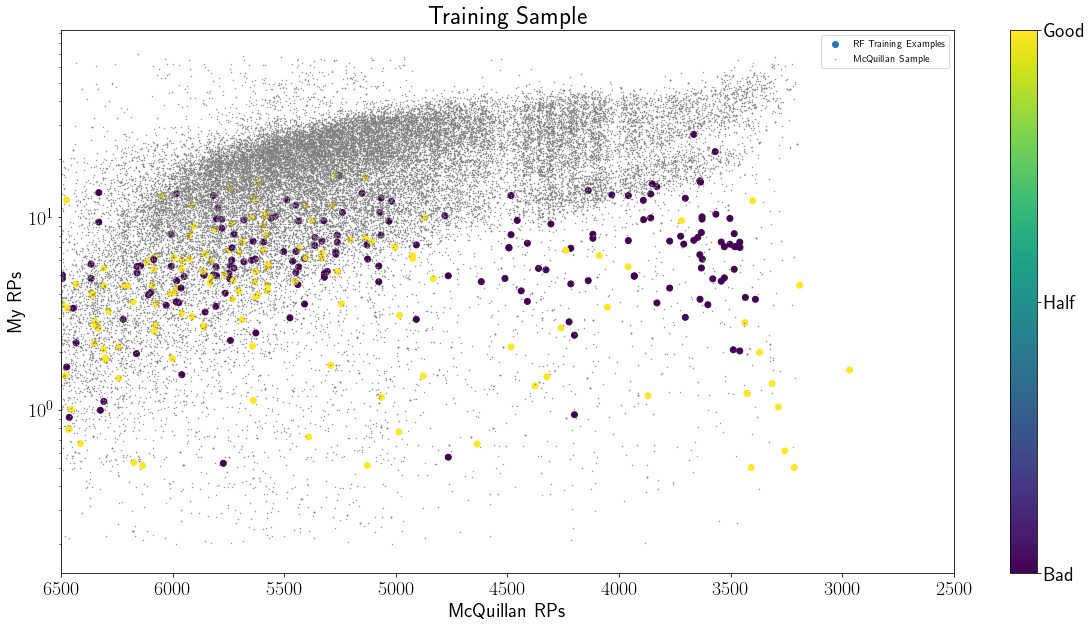

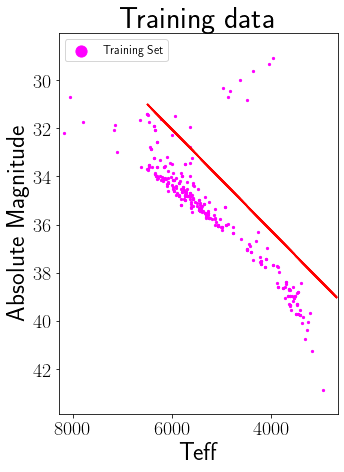

In [32]:
#check for giants

## add Abs_Mag column & find division line ---to remove giants from unseen & training data
t_abs_GAIAmag = []
t_teffs =[]
for plx,mag,temp in fulltable2[['plx','GAIAmag','Teff']].to_numpy():
    D = get_D(plx)
    newmag=abs_mag(mag,D)
    t_abs_GAIAmag.append(newmag)
    t_teffs.append(temp)
#add to df
fulltable2['GAIA_AbsMag'] = t_abs_GAIAmag

#determine division line params
t_pt1 = [6500,31]
t_pt2 = [2700,39]
t_m = slope(t_pt1[0],t_pt2[0],t_pt1[1],t_pt2[1])
t_b = get_b(t_m,t_pt1[0],t_pt1[1])
#create arrays for line
t_xarr = np.arange(t_pt2[0],t_pt1[0],1)
t_yarr = [t_m*x + t_b for x in t_xarr]

#plot
plt.figure(figsize=(5,7))
# plt.scatter(u_teffs,u_abs_GAIAmag,s=.2,label='Unseen data to confirm MS',color='lightgrey')
plt.scatter(t_teffs,t_abs_GAIAmag,s=5,label='Training Set',color='magenta')
plt.scatter(t_xarr,t_yarr,color='r',s=.2)
plt.legend(fontsize='large',markerscale=5)
plt.ylabel('Absolute Magnitude');plt.xlabel('Teff');
plt.xlim(max(t_teffs)+100,min(t_teffs)-300)
plt.ylim(max(t_abs_GAIAmag)+1,min(t_abs_GAIAmag)-1);
plt.title('Training data',fontsize=30);



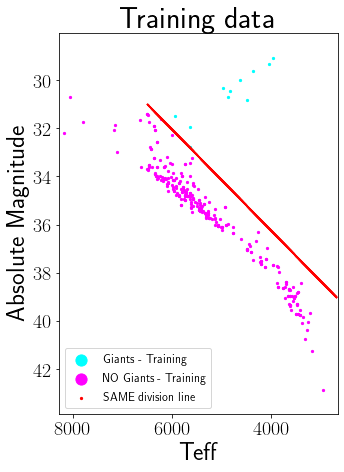

In [33]:
#removing giants from training sample

#do cut for features
compare_values = [t_m*x + t_b for x in fulltable2['Teff'].to_numpy()] #ABSmagnitude value on the red line at star's teff
features_nogiants = fulltable2[[fulltable2['GAIA_AbsMag'].to_numpy()[i] > compare_values[i] for i in range(len(compare_values))]]
features_giantsonly = fulltable2[[fulltable2['GAIA_AbsMag'].to_numpy()[i] <= compare_values[i] for i in range(len(compare_values))]]
######## note that both "compare_values" are the SAME

plt.figure(figsize=(5,7))
# plt.scatter(u_teffs,u_abs_GAIAmag,s=.2,label='Unseen data to confirm MS',color='lightgrey')
plt.scatter(features_giantsonly['Teff'].to_numpy(),features_giantsonly['GAIA_AbsMag'].to_numpy(),s=5,label='Giants - Training',color='cyan')
plt.scatter(features_nogiants['Teff'].to_numpy(),features_nogiants['GAIA_AbsMag'].to_numpy(),s=5,label='NO Giants - Training',color='magenta')
plt.scatter(t_xarr,t_yarr,color='r',s=.2,label='SAME division line')
plt.legend(fontsize='large',markerscale=5)
plt.ylabel('Absolute Magnitude');plt.xlabel('Teff');
plt.xlim(max(t_teffs)+100,min(t_teffs)-300)
plt.ylim(max(t_abs_GAIAmag)+1,min(t_abs_GAIAmag)-1);
plt.title('Training data',fontsize=30);



In [ ]:
from matplotlib import cm

fig, ax = plt.subplots(figsize=(20,10))

cax = plt.scatter(fulltable2['Teff'].to_numpy(),fulltable2['ls-1'].to_numpy(),c=fulltable2['Label'].to_numpy(),label='RF Training Examples')
ax.scatter(mq['TEMP'],mq['ROTATION_PERIOD'].to_numpy(),color='grey',s=.2,rasterized=True,label='McQuillan Sample')
ax.set_title('Training Sample',fontsize=25)
ax.legend()
ax.set_xlabel('McQuillan RPs',fontsize=20);plt.ylabel('My RPs',fontsize=20);
# ax.set_xlim(8500,2500);
ax.set_xlim(6500,2500);ax.set_yscale('log')


# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, ticks=[1,2, 3])
cbar.ax.set_yticklabels(['Bad','Half',  'Good']);  # vertically oriented colorbar

In [40]:
## isolate labels & features
labels = fulltable2['Label'].to_numpy()
features = fulltable2.drop(['Label','plx','GAIAmag','GAIA_AbsMag'],1) #1 for column axis
print('labels:',len(labels),labels) #sanity check

## inject random variable
np.random.seed(seed = 11)
features['random'] = np.random.random(size = len(features))

features #sanity check

labels: 321 [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


,TIC,Sector,rvar,ls-1,ls-2,ls-3,lsamp-1,lsamp-2,lsamp-3,Teff,random
14,27773745,14.0,380.604883,4.158775,5.952853,3.385456,0.465720,0.194725,0.123022,5574.83,0.180270
15,27773745,15.0,486.554688,4.458739,6.426258,3.470604,0.695522,0.346239,0.099978,5574.83,0.019475
16,27776588,14.0,82.093555,12.513233,4.943627,7.176907,0.041240,0.034363,0.027161,5639.18,0.463219
19,27843903,14.0,120.960645,0.791619,0.761929,0.824778,0.521894,0.182164,0.103832,6465.00,0.724934
20,27843903,15.0,87.112500,0.796663,0.767347,0.832418,0.157814,0.106211,0.092238,6465.00,0.420204
...,...,...,...,...,...,...,...,...,...,...,...
90,279570232,14.5,0.048632,1.118518,1.127910,0.558443,0.231829,0.178198,0.149758,5638.71,0.762430
91,349152048,14.5,0.014203,0.667290,0.665706,0.675185,0.599031,0.098220,0.039032,6413.00,0.642983
92,349154435,14.5,0.014492,4.547054,2.216561,4.635532,0.060046,0.018639,0.014601,5832.00,0.447966
93,358510596,14.5,0.002464,0.664410,0.556352,0.589544,0.018086,0.017529,0.015374,4636.00,0.709981


In [41]:
print('This model will use {} features:\n'.format(len(features.columns)),list(features.columns))
print('\nLabels for this model include {}-Good; {}-Bad; {}-Half harmonics'.format(len(fulltable2[fulltable2['Label'].to_numpy()==3]),len(fulltable2[fulltable2['Label'].to_numpy()==1]),len(fulltable2[fulltable2['Label'].to_numpy()==2])))

This model will use 11 features:
 ['TIC', 'Sector', 'rvar', 'ls-1', 'ls-2', 'ls-3', 'lsamp-1', 'lsamp-2', 'lsamp-3', 'Teff', 'random']

Labels for this model include 148-Good; 173-Bad; 0-Half harmonics


# Build, train, test RF classifier

In [42]:
#set variable for feature data
x = features 
#set variable for correct labels
y = labels
#split data into test and training set
x_train, test_x, y_train, test_y = train_test_split(x, y, random_state = 11)

In [43]:
######play with parms here to get better model


#define random forest model
rf_model = RandomForestClassifier(n_estimators = 200,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 11,
                           max_depth = 4) #criterion='entropy'
# fit model to data
rf_model.fit(x_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=200, n_jobs=-1, oob_score=True,
                       random_state=11)

Test Set Accuracy: 0.8765432098765432
Training Set Accuracy: 0.975
Out of the Box Accuracy: 0.8875
Validation Set: 87.65 87.65
Confusion Matrix:
[[41  5]
 [ 5 30]]


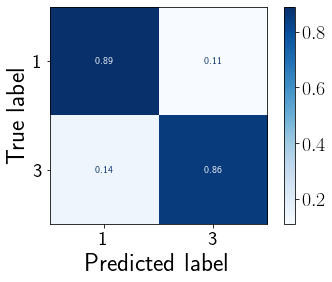

In [44]:
## print accuracy scores
print('Test Set Accuracy:',rf_model.score(test_x, test_y))  
print('Training Set Accuracy:', rf_model.score(x_train, y_train))
print('Out of the Box Accuracy:',rf_model.oob_score_)

#just another way to have syntax handy
# have fit model predict labels for previously unseen data
test_predictions = rf_model.predict(test_x)
# check the accuracy of fit model
test_score = rf_model.score(test_x, test_y)
test_accuracy = accuracy_score(test_y, test_predictions)
print('Validation Set:',"%.2f" % (test_accuracy*100), "%.2f" % (test_score*100))


## confusion matrix of test set

conf_mat = confusion_matrix(test_y, test_predictions)
print('Confusion Matrix:')
print(conf_mat) #see matrix
#plot matrix
disp = plot_confusion_matrix(rf_model, test_x, test_y,
cmap=plt.cm.Blues, normalize='true')


# Cross Validation - leave one out

In [45]:
#set variable for feature data
x = features.reset_index(drop=True) #so index is in order and old index isnt added as a column 
#set variable for correct labels
y = labels
#split data into test and training set w/o sklearn 
# for i in range(len(features)):
    
# list(features.index)
x[0:2]
# x_train_cv, test_x_cv, y_train_cv, test_y_cv = train_test_split(x, y, random_state = 11)

,TIC,Sector,rvar,ls-1,ls-2,ls-3,lsamp-1,lsamp-2,lsamp-3,Teff,random
0,27773745,14.0,380.604883,4.158775,5.952853,3.385456,0.465720,0.194725,0.123022,5574.83,0.180270
1,27773745,15.0,486.554688,4.458739,6.426258,3.470604,0.695522,0.346239,0.099978,5574.83,0.019475


In [46]:
#input: features,labels
# divide data to train(80),test(19),validate(1)
predictions = [] #collect predictions for loo - can add to df as a column b/c loo goes in order
for count,idx in enumerate(range(len(x))):
    ##get validation set
    loo_x = x.iloc[idx]
    loo_y = y[idx]
    ##remove validation data from features/labels
    x_after_loo = x.drop(index = idx)
    y_after_loo = np.delete(y, idx)
    ##split remaining data into training & testing
    x_train_cv, test_x_cv, y_train_cv, test_y_cv = train_test_split(x_after_loo, y_after_loo, random_state = 11)
    ##setup model
    rf_model = RandomForestClassifier(n_estimators = 200,
                           n_jobs = -1,
                           oob_score = True,
                           bootstrap = True,
                           random_state = 11,
                           max_depth = 4) 
    ##fit model with train data
    rf_model.fit(x_train_cv, y_train_cv)
    ##make loo into a df b/c model is picky b/c its only one example
    mydic = {'TIC':loo_x['TIC'],'Sector':loo_x['Sector'],'rvar':loo_x['rvar'],'ls-1':loo_x['ls-1'],'ls-2':loo_x['ls-2'],
            'ls-3':loo_x['ls-3'],'lsamp-1':loo_x['lsamp-1'],'lsamp-2':loo_x['lsamp-2'],'lsamp-3':loo_x['lsamp-3'],
                    'Teff':loo_x['Teff'],'random':loo_x['random']}
    loo_x_df = pd.DataFrame(mydic,index=[0])
    ##predict for validate target
    validation_prediction = rf_model.predict(loo_x_df) 
    ##save predictions
    predictions.append(validation_prediction[0])
    
# predictions    



In [47]:
##add to df
x['prediction'] = predictions
x['truth'] = y
x

,TIC,Sector,rvar,ls-1,ls-2,ls-3,lsamp-1,lsamp-2,lsamp-3,Teff,random,prediction,truth
0,27773745,14.0,380.604883,4.158775,5.952853,3.385456,0.465720,0.194725,0.123022,5574.83,0.180270,3,3
1,27773745,15.0,486.554688,4.458739,6.426258,3.470604,0.695522,0.346239,0.099978,5574.83,0.019475,3,3
2,27776588,14.0,82.093555,12.513233,4.943627,7.176907,0.041240,0.034363,0.027161,5639.18,0.463219,1,3
3,27843903,14.0,120.960645,0.791619,0.761929,0.824778,0.521894,0.182164,0.103832,6465.00,0.724934,3,3
4,27843903,15.0,87.112500,0.796663,0.767347,0.832418,0.157814,0.106211,0.092238,6465.00,0.420204,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,279570232,14.5,0.048632,1.118518,1.127910,0.558443,0.231829,0.178198,0.149758,5638.71,0.762430,3,3
317,349152048,14.5,0.014203,0.667290,0.665706,0.675185,0.599031,0.098220,0.039032,6413.00,0.642983,3,3
318,349154435,14.5,0.014492,4.547054,2.216561,4.635532,0.060046,0.018639,0.014601,5832.00,0.447966,3,3
319,358510596,14.5,0.002464,0.664410,0.556352,0.589544,0.018086,0.017529,0.015374,4636.00,0.709981,3,3


In [48]:
#match to mq
header_list = ['TIC','KIC','MQ_Prot']
cmatch = pd.read_csv('data/useful_catalogs/tics_kics_mcq_rot.txt',delimiter=' ',names=header_list)
mq_predictions = x.merge(cmatch, left_on='TIC',right_on='TIC')
mq_predictions

,TIC,Sector,rvar,ls-1,ls-2,ls-3,lsamp-1,lsamp-2,lsamp-3,Teff,random,prediction,truth,KIC,MQ_Prot
0,27773745,14.0,380.604883,4.158775,5.952853,3.385456,0.465720,0.194725,0.123022,5574.83,0.180270,3,3,11200185,4.36
1,27773745,15.0,486.554688,4.458739,6.426258,3.470604,0.695522,0.346239,0.099978,5574.83,0.019475,3,3,11200185,4.36
2,27776588,14.0,82.093555,12.513233,4.943627,7.176907,0.041240,0.034363,0.027161,5639.18,0.463219,1,3,11923356,14.13
3,27776588,15.0,82.438672,7.496492,12.827884,5.275127,0.058730,0.044180,0.022301,5639.18,0.020733,1,1,11923356,14.13
4,27843903,14.0,120.960645,0.791619,0.761929,0.824778,0.521894,0.182164,0.103832,6465.00,0.724934,3,3,12418959,0.78
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,158273158,15.0,71.861328,6.062904,13.605417,7.897393,0.042838,0.026265,0.020667,5629.68,0.223638,1,1,9760362,17.95
222,159171617,15.0,61.229785,4.031304,5.056476,6.795469,0.086299,0.057243,0.046907,5764.52,0.234289,1,1,9826171,10.72
223,159172010,15.0,56.993359,7.508752,5.348873,13.090554,0.007145,0.004948,0.004457,5331.05,0.482361,1,1,10006542,30.90
224,298964604,15.0,48.636133,13.060087,6.779961,3.472752,0.010857,0.007666,0.002652,4032.33,0.493554,1,1,11237492,21.35


# -------------------------------------------------------------------------------------
# The below cells are for LOO_CV predictions & accuracy using only 2 classes
## Halfs as BAD

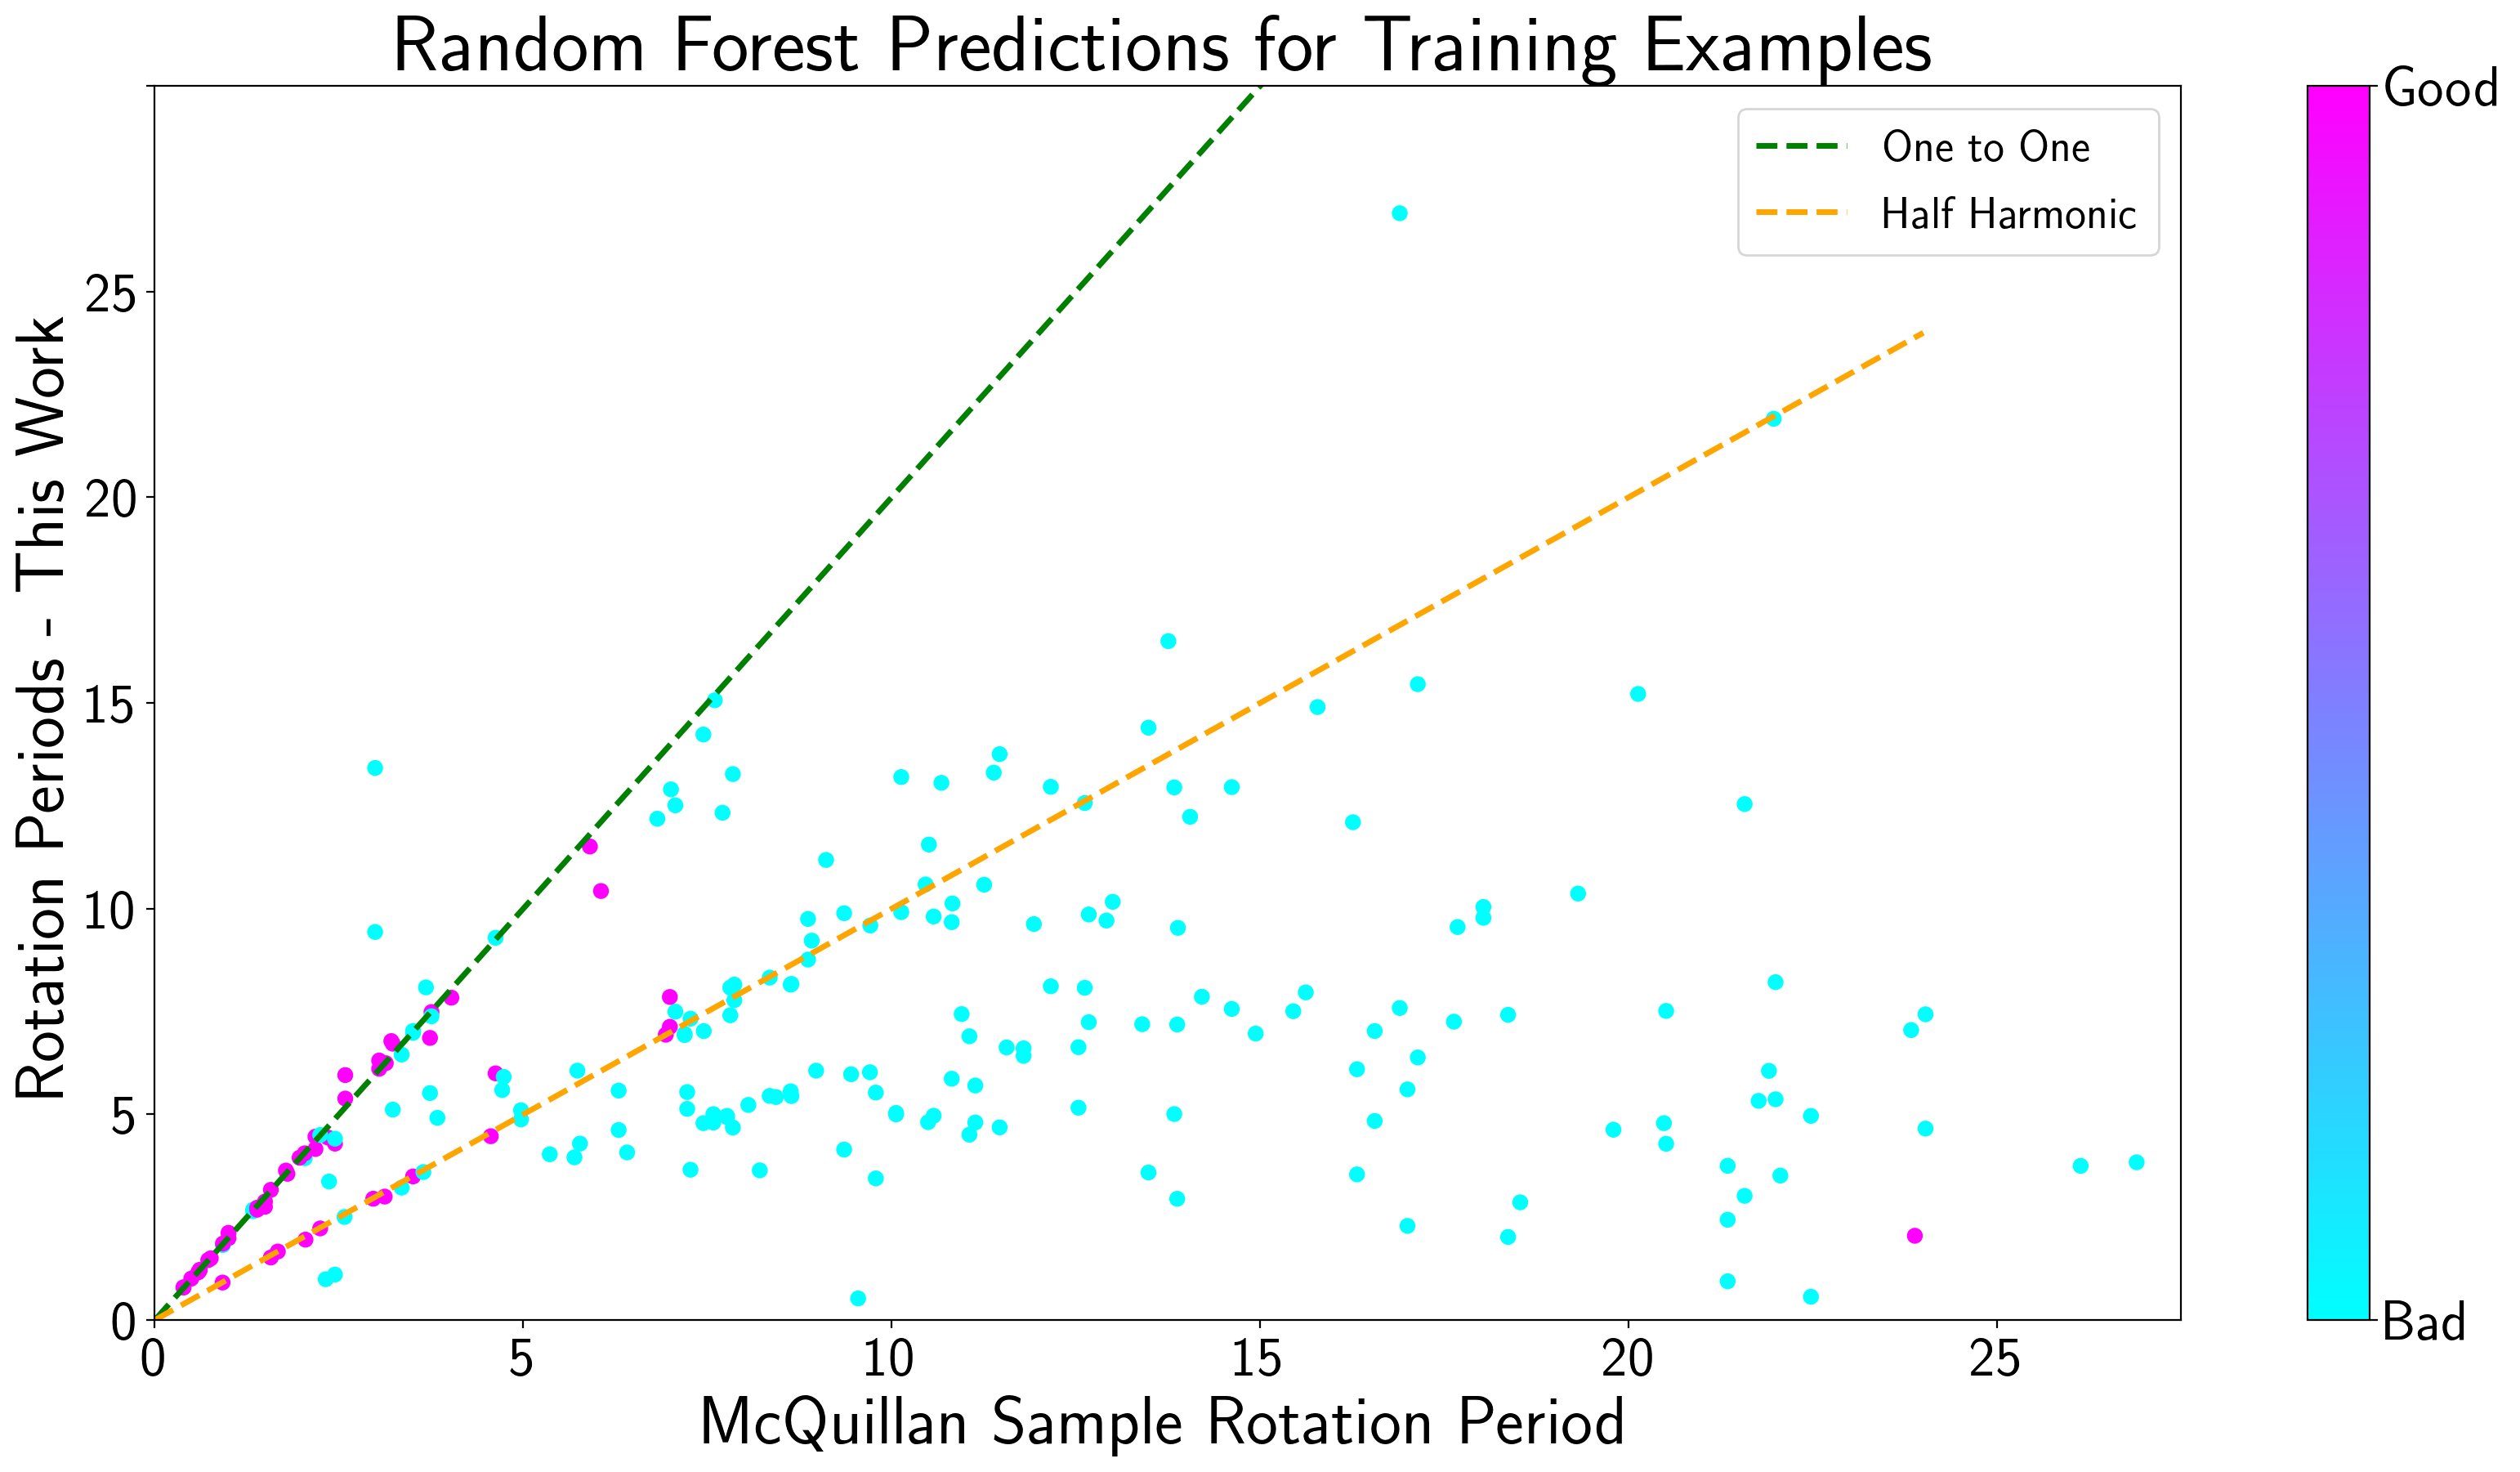

In [49]:
##use this one - made dashed linewidths wider

from matplotlib import cm

fig, ax = plt.subplots(figsize=(20,10),dpi=200)

# data = (mq_predictions['MQ_Prot'].to_numpy(),mq_predictions['ls-1'].to_numpy())
ax.plot(np.arange(0,50,2),np.arange(0,50,2),ls='--',lw=2.5,color='g',label='One to One')
ax.plot(np.arange(0,50,2),np.arange(0,25,1),ls='--',lw=2.5,color='orange',label='Half Harmonic')


cax = ax.scatter(mq_predictions['MQ_Prot'].to_numpy(),mq_predictions['ls-1'].to_numpy(),cmap=cm.cool, c =mq_predictions['prediction'].to_numpy())
# ax.set_title('Testing colorbar')
# ax.colorbar().set_label('Predicted Class',fontsize=20)
ax.legend(fontsize=20)
# ax.set_title('LOO_CV Predictions: with Half Harmonics labeled as BAD',fontsize=25)
ax.set_title('Random Forest Predictions for Training Examples',fontsize=35)
ax.set_xlabel('McQuillan Sample Rotation Period',fontsize=30);plt.ylabel('Rotation Periods - This Work',fontsize=30);
ax.set_ylim(0,30),ax.set_xlim(0,55);
ax.set_xticklabels(np.arange(0,60,5),fontsize=25)
ax.set_yticklabels(np.arange(0,30,5),fontsize=25)


# Add colorbar, make sure to specify tick locations to match desired ticklabels
cbar = fig.colorbar(cax, ticks=[1, 3],cmap=cm.cool)
cbar.ax.set_yticklabels(['Bad',  'Good'],fontsize=25);  # vertically oriented colorbar

# plt.savefig('data/talk_plots/RF_TrainingSet_predictions.jpg')

In [50]:
#accuracy calclation

acc = 0; inacc=0; wrongs=0; rights=0; total_goods=0; total_bads=0;false_positives=0;false_negatives =0
for idx in range(len(mq_predictions)):
    true_cat = mq_predictions['truth'].iloc[idx]
    predict_cat = mq_predictions['prediction'].iloc[idx]
    if true_cat == predict_cat:
        acc +=1
        if true_cat == 1: #both are bad
            wrongs +=1
            #false_negatives +=1
        else: #both good
            rights +=1
            
    else:
        inacc +=1
        if predict_cat == 1: #predicted bad when really was good
            false_negatives +=1
        else: # predicted good when realy was bad
            false_positives +=1
            
    if true_cat == 3:
        total_goods += 1 #total number of good truths
    else:
        total_bads +=1 #total number of bad truths
        
overall_acc = acc/len(mq_predictions) * 100
overall_inacc = inacc/len(mq_predictions) * 100
print('Overall Percent Accurate:',overall_acc)
print('Overall Percent Inaccurate:',overall_inacc)
print('Sanity Check Sum:', overall_inacc + overall_acc)
print('\nBreakdown of Overall Accuracy')
print('Good Accuracy:',rights/total_goods *100)
print('Bad Accuracy:', wrongs/total_bads * 100)
print('False Positive Percentage:',false_positives/len(mq_predictions) * 100)
print('False Negative Percentage:',false_negatives/len(mq_predictions) * 100)

Overall Percent Accurate: 86.28318584070797
Overall Percent Inaccurate: 13.716814159292035
Sanity Check Sum: 100.0

Breakdown of Overall Accuracy
Good Accuracy: 67.9245283018868
Bad Accuracy: 91.90751445086705
False Positive Percentage: 6.1946902654867255
False Negative Percentage: 7.52212389380531


# ---------------------------------------------------------------------------
# Feature Importances

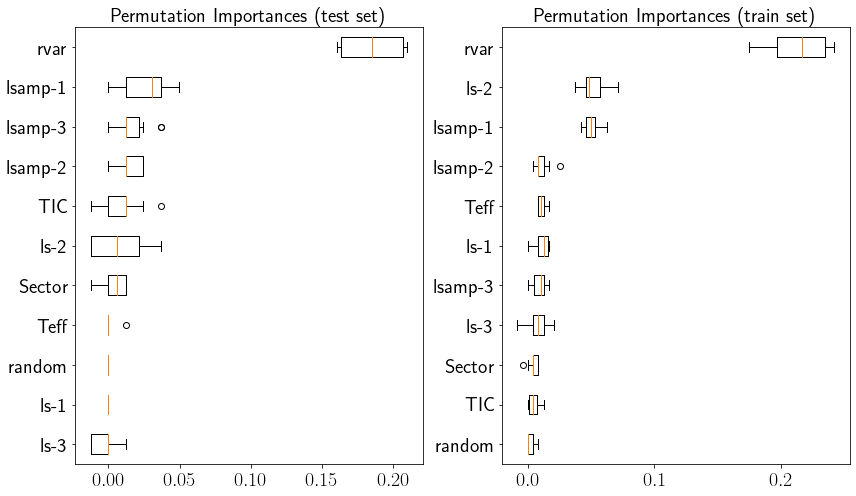

In [52]:
# permutation_importance (one for TRAIN dataset; one for TEST dataset)

result = permutation_importance(rf_model, test_x, test_y, n_repeats=10,
                                random_state=11, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,7))
ax1.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=test_x.columns[sorted_idx])
ax1.set_title("Permutation Importances (test set)",fontsize=20)


result2 = permutation_importance(rf_model, x_train, y_train, n_repeats=10,
                                random_state=11, n_jobs=2)
sorted_idx2 = result2.importances_mean.argsort()
ax2.boxplot(result2.importances[sorted_idx2].T,
           vert=False, labels=x_train.columns[sorted_idx2])
ax2.set_title("Permutation Importances (train set)",fontsize=20)

fig.tight_layout()
plt.show()

In [53]:
# permutation importance -- a googled way - not sklearn
def r22(rf, x_train, y_train):
    return r2_score(y_train, rf.predict(x_train))

perm_imp_rfpimp2 = permutation_importances(rf_model, x_train, y_train, r22)
# import matplotlib.pyplot as plt
# plt.barh(perm_imp_rfpimp.index,perm_imp_rfpimp[['Importance']])
perm_imp_rfpimp2.plot.barh(figsize=(15,10))
plt.xlabel('Feature_Importance');

RuntimeError: latex was not able to process the following string:
b'Feature_Importance'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/helenfellow/.matplotlib/tex.cache/91a4ea68d8cebb13b16b443b2d91d68e.tex
LaTeX2e <2018-12-01>
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2019/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.def
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./91a4ea68d8cebb13b16b443b2d91d68e.aux)
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.14 ...e{25.000000}{31.250000}{\sffamily Feature_
                                                  Importance}
No pages of output.
Transcript written on 91a4ea68d8cebb13b16b443b2d91d68e.log.




<Figure size 1080x720 with 1 Axes>

In [54]:
# sklearn - impurity based feature importance (uses training set)

importances2 = rf_model.feature_importances_
std2 = np.std([tree.feature_importances_ for tree in rf_model.estimators_],
             axis=0)
indices2 = np.argsort(importances2)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices2[f], importances2[indices2[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(15,10))
plt.title("Feature importances",fontsize=25)
plt.bar(range(x.shape[1]), importances2[indices2],
       color="r", yerr=std2[indices2], align="center")
degrees = 70
plt.xticks(range(x.shape[1]), x.columns[indices2],fontsize=18,rotation=degrees)
plt.xlim([-1, x.shape[1]])
plt.yticks(fontsize=18)
plt.show()

Feature ranking:
1. feature 2 (0.289447)
2. feature 6 (0.135054)
3. feature 7 (0.105704)
4. feature 8 (0.093425)
5. feature 1 (0.084814)
6. feature 4 (0.084720)
7. feature 3 (0.077349)
8. feature 5 (0.041238)
9. feature 0 (0.040293)
10. feature 9 (0.035444)
11. feature 10 (0.012512)


IndexError: index 11 is out of bounds for axis 0 with size 11

# Make Predictions
###### first format the unseen data for model

In [58]:
unseen_RF2_results.columns, len(unseen_RF2_results)

(Index(['TIC', 'rvar', 'Teff', 'ls1', 'ls2', 'ls3', 'lsamp1', 'lsamp2',
        'lsamp3', 'power', 'period', 'depth', 'transittime', 'duration', 'Vmag',
        'Tmag', 'random', 'predict_class'],
       dtype='object'),
 9646)

In [57]:
#this is too many matches!!!!!!!!!!!!!


#match to all data to get sector
unseen_allstats = pd.merge(unseen_RF2_results,allstats, left_on=['TIC','power'], right_on=['TIC','power_bls'])
unseen_allstats                           

,TIC,rvar_x,Teff_x,ls1,ls2,ls3,lsamp1,lsamp2,lsamp3,power,...,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID
0,100008376,41.565918,4260.00,5.966919,14.832070,8.408888,0.052525,0.041702,0.040984,3,...,NaN,0.778199,0.608174,172.594452,64.296247,0.024917,0.020003,1,0,143482901
1,100010286,343.870508,4066.00,6.490677,10.919687,4.590450,0.611177,0.411933,0.153213,55,...,NaN,0.650925,0.569246,172.805184,63.157644,0.018637,0.018574,1,0,143483869
2,100011130,110.547852,6178.00,6.327233,9.736584,18.670184,0.050489,0.042151,0.008676,153,...,NaN,0.728036,0.710188,172.980337,62.517275,0.018674,0.020107,1,0,143484401
3,100011208,44.024072,5786.00,6.614793,4.799858,14.075604,0.016676,0.009957,0.006409,48,...,NaN,1.047266,0.947109,172.986686,62.050373,0.029882,0.030739,1,0,143484422
4,100011351,2164.406250,6163.81,3.376855,13.866910,6.327233,0.035589,0.030294,0.020189,16,...,NaN,9.356969,9.540352,173.086115,61.082209,0.292335,0.282867,1,0,143565767
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9721,99936804,51.038281,4924.00,1.991261,6.392907,1.060350,0.012843,0.009555,0.008614,9,...,NaN,0.737344,0.677820,169.924913,63.460754,0.020488,0.020215,1,0,142994292
9722,99956360,227.912500,6013.02,9.945577,5.971858,4.634256,0.215262,0.170118,0.047122,4,...,NaN,0.867590,0.829796,171.065568,65.045116,0.025660,0.027336,1,0,143243048
9723,99988199,46.279150,4865.00,11.897165,7.601423,4.717806,0.095436,0.033020,0.032174,28,...,NaN,0.723434,0.648032,171.879720,64.296178,0.019699,0.019341,1,0,143322493
9724,99989665,24.063239,3149.00,3.320681,4.045188,6.437726,0.165936,0.020755,0.016282,25,...,cooldwarfs_v8,1.753273,1.593195,172.359806,62.125333,0.052553,0.052011,1,0,143403992


In [70]:
print('TIC', 'Sector', 'rvar', 'ls-1', 'ls-2', 'ls-3', 'lsamp-1', 'lsamp-2', 'lsamp-3', 'Teff', 'random')

TIC Sector rvar ls-1 ls-2 ls-3 lsamp-1 lsamp-2 lsamp-3 Teff random


In [71]:
#select columns
unseen_data = unseen_allstats[['TIC','Sector', 'rvar_x', 'Teff_x', 'ls1', 'ls2', 'ls3', 'lsamp1', 'lsamp2',
       'lsamp3', 'random']]
#rename to match model features
unseen_data = unseen_data.rename(columns={"rvar_x": 'rvar','Teff_x':'Teff','ls1':'ls-1',
                                         'ls2':'ls-2','ls3':'ls-3','lsamp1':'lsamp-1',
                                         'lsamp2':'lsamp-2','lsamp3':'lsamp-3'})


unseen_data

,TIC,Sector,rvar,Teff,ls-1,ls-2,ls-3,lsamp-1,lsamp-2,lsamp-3,random
0,100008376,14,41.565918,4260.00,5.966919,14.832070,8.408888,0.052525,0.041702,0.040984,0.180270
1,100010286,14,343.870508,4066.00,6.490677,10.919687,4.590450,0.611177,0.411933,0.153213,0.019475
2,100011130,14,110.547852,6178.00,6.327233,9.736584,18.670184,0.050489,0.042151,0.008676,0.463219
3,100011208,14,44.024072,5786.00,6.614793,4.799858,14.075604,0.016676,0.009957,0.006409,0.724934
4,100011351,14,2164.406250,6163.81,3.376855,13.866910,6.327233,0.035589,0.030294,0.020189,0.420204
...,...,...,...,...,...,...,...,...,...,...,...
9721,99936804,15,51.038281,4924.00,1.991261,6.392907,1.060350,0.012843,0.009555,0.008614,0.319481
9722,99956360,15,227.912500,6013.02,9.945577,5.971858,4.634256,0.215262,0.170118,0.047122,0.238499
9723,99988199,15,46.279150,4865.00,11.897165,7.601423,4.717806,0.095436,0.033020,0.032174,0.100988
9724,99989665,15,24.063239,3149.00,3.320681,4.045188,6.437726,0.165936,0.020755,0.016282,0.703921


In [72]:
# get predicitons 
unseen_predictions = rf_model.predict(unseen_data) #(1+ sectors)

unseen_predictions

array([3, 3, 3, ..., 3, 3, 3])

UNSEEN DATA SIZE =  9726


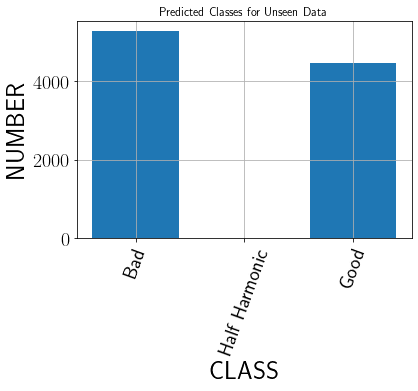

In [73]:
#visualize prediction distribution


bins = np.arange(1,5,1)
x2 = np.histogram(unseen_predictions,bins)[0]
predictsize_1 = len(unseen_data)
print('UNSEEN DATA SIZE = ', predictsize_1)
            
y2 = bins[:-1]
plt.bar(y2,x2)
plt.grid('on')
plt.xlabel('CLASS')
plt.ylabel('NUMBER')
degrees = 70
plt.xticks(range(1,x2.shape[0]+1),[label_meanings(i) for i in y2],rotation=degrees)
plt.title('Predicted Classes for Unseen Data');

In [75]:
#match tics to check individual predicitons

predicted_table = Table([unseen_data['TIC'],unseen_data['Sector'],unseen_predictions,unseen_data['ls-1'],unseen_data['ls-2'],unseen_data['Teff']],names=('TIC','Sector','predict_class','ls-1','ls-2','Teff'))
# predicted_table FROM RF
bad = [int(i) for count,i in enumerate(predicted_table['TIC']) if predicted_table['predict_class'][count] ==1]
half = [int(i) for count,i in enumerate(predicted_table['TIC']) if predicted_table['predict_class'][count] ==2]
good = [int(i) for count,i in enumerate(predicted_table['TIC']) if predicted_table['predict_class'][count] ==3]

print('goods: {} \nbads: {}  \nhalfs: {}'.format(len(good),len(bad),len(half)))

goods: 4460 
bads: 5266  
halfs: 0


In [76]:
bad_table = predicted_table[predicted_table['predict_class']==1] #bads
good_table = predicted_table[predicted_table['predict_class']==3] #goods
print('there are {} good predicted rot.periods out of {} total stars'.format(len(good_table),len(predicted_table)))

there are 4460 good predicted rot.periods out of 9726 total stars


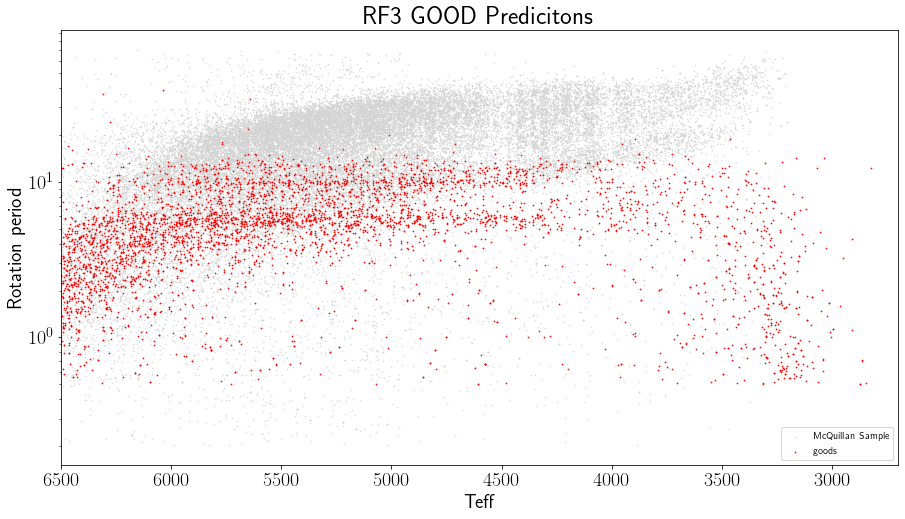

In [77]:
#plot 'goods' from this RF to see M feature
f =plt.figure(figsize=(15,8))
plt.scatter(mq['TEMP'],mq['ROTATION_PERIOD'].to_numpy(),color='lightgrey',s=.2,rasterized=True,label='McQuillan Sample')
plt.scatter(good_table['Teff'],good_table['ls-1'],s=.5,label='goods',color='r')
plt.ylabel('Rotation period',fontsize=20); plt.xlabel('Teff',fontsize=20)
plt.title('RF3 GOOD Predicitons',fontsize=25)
plt.legend()
plt.yscale('log')
plt.xlim(6500,2700);

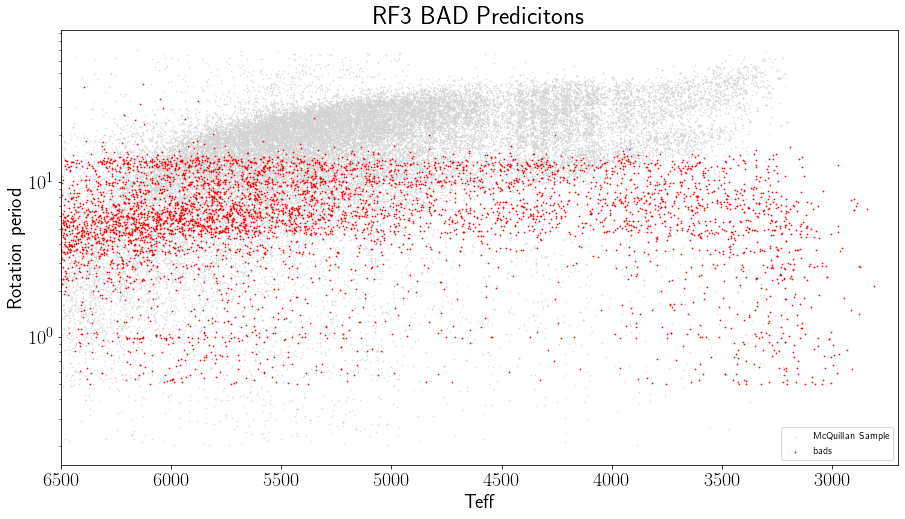

In [78]:
#plot 'goods' from this RF to see M feature
f =plt.figure(figsize=(15,8))
plt.scatter(mq['TEMP'],mq['ROTATION_PERIOD'].to_numpy(),color='lightgrey',s=.2,rasterized=True,label='McQuillan Sample')
plt.scatter(bad_table['Teff'],bad_table['ls-1'],s=.5,label='bads',color='r')
plt.ylabel('Rotation period',fontsize=20); plt.xlabel('Teff',fontsize=20)
plt.title('RF3 BAD Predicitons',fontsize=25)
plt.legend()
plt.yscale('log')
plt.xlim(6500,2700);

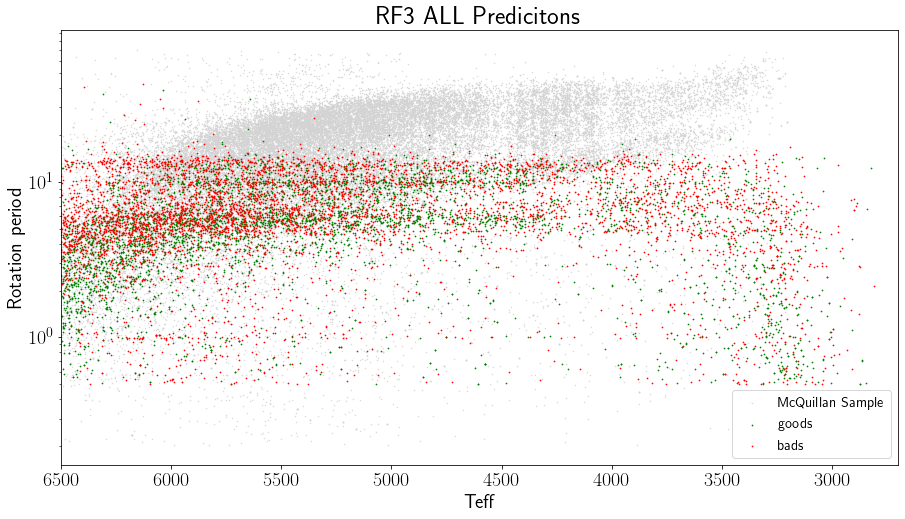

In [80]:
#plot 'goods' from this RF to see M feature
f =plt.figure(figsize=(15,8))
plt.scatter(mq['TEMP'],mq['ROTATION_PERIOD'].to_numpy(),color='lightgrey',s=.2,rasterized=True,label='McQuillan Sample')
plt.scatter(good_table['Teff'],good_table['ls-1'],s=.5,label='goods',color='g')
plt.scatter(bad_table['Teff'],bad_table['ls-1'],s=.5,label='bads',color='r')
plt.ylabel('Rotation period',fontsize=20); plt.xlabel('Teff',fontsize=20)
plt.title('RF3 ALL Predicitons',fontsize=25)
plt.legend(fontsize='x-large')
plt.yscale('log')
plt.xlim(6500,2700);